# Vision Transformers

1. Reshape input image into sequence of flattened 2d patches.
2. Pass flattened patches through trainable linear projection to obtain D dimensions. This output is called the patch embeddings. We will then prepend / concatenate a learnable [class] token to the entire sequence of patch embeddings.
4. Add to each patch embedding the positional embedding (element-wise) to represent the patch position in the sequence (learnable 1D embeddings).
5. Pass embedded patches through transformer encoder consisting of multiple layers of multi head attention and MLP blocks. Encoder is slightly modified, moving the layer normalization before the multi head self attention and MLP layers (see diagram in paper).
6. Pass encoder output for the [class] token embedding to a classification head (feed forward MLP) to obtain the class probabilities (using softmax). Prior to passing through the classification head, the output may first be passed through another normalization layer.

The encoder applies self attention across the patch embeddings and the [class] token. The [class] token interacts with all patch embeddings, learning to aggregate global information about the image as the encoder processes the sequence.

The encoder output corresponding to the [class] token is fed through an optional normalization layer, and then a classification head (an MLP  using GELU activations). The MLP:
- During pre-training: is a two layer feed forward network with one hidden layer and one linear layer (for more expressive learning)
- During fine-tuning: is a single linear layer (reducing complexity, to avoid over-fitting on smaller datasets)

![vision-transformer](vision-transformer.png)

# Data Exploration

We'll take a smaller dataset for data exploration and experimenting with the vision transformer architecture. This dataset is CIFAR-10, a collection of 60,000 color images with 10 classes (6k images per class, images are 32x32 in RGB format). There are 50,000 training and 10,000 test images.

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-11-26 08:30:19.969336: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2024-11-26 08:30:20.055795: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2024-11-26 08:30:20.151071: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2024-11-26 08:30:20.272570: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2024-11-26 08:30:20.458253: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, a

2024-11-26 08:30:20.925912: I external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

I0000 00:00:1732609825.565063     159 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732609825.565358     159 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732609825.565500     159 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732609825.678419     159 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Shuffling /home/jovyan/tensorflow_datasets/cifar10/incomplete.KRZVSY_3.0.2/cifar10-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/cifar10/incomplete.KRZVSY_3.0.2/cifar10-test.tfrecord*...:   0%|   …

Dataset cifar10 downloaded and prepared to /home/jovyan/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


2024-11-26 08:31:01.099115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-26 08:31:01.107703: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


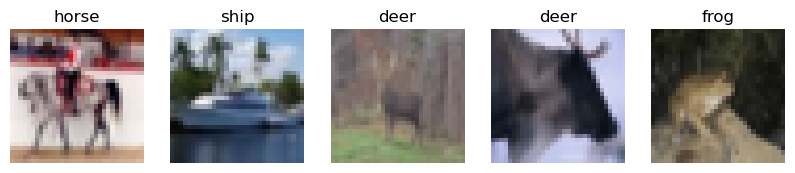

In [5]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

os.environ["NO_GCE_CHECK"] = "true"

# Load dataset
dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True, data_dir="~/tensorflow_datasets/")
train_dataset, test_dataset = dataset["train"], dataset["test"]

# CIFAR-10 label names
label_names = info.features["label"].int2str

# Display a few images, these are stored as image tensors with shape (32, 32, 3) / (height, width, channels)
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(train_dataset.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(label_names(label))
    plt.axis('off')
plt.show()

# 1. Reshape and Flatten Images 

This step involves first reshaping each input image into a sequence of flattened 2D patches. The layers will be designed flexibly, handling variable image input sizes and configurable patch sizes.

In [6]:
import tensorflow as tf

class PatchConverter(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # get shape of input image tensor and extract batch size
        patches = tf.image.extract_patches( # similar to applying a convolution, extracting patches from the image
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], # sampling rate set to 1 (no dilation)
            padding="VALID"
        )
        patch_dim = patches.shape[-1] # last dimension of patches is the flattened patch size (e.g. 4x4 patches is 48 - 4x4x3)
        patches = tf.reshape(patches, [batch_size, -1, patch_dim]) # reshape patches into 3D tensor of shape [batch_size, total patches per image, flattened patch size]
        return patches

Using the CIFAR-10 image dimensions (32x32), and a patch size of 4 as an example, we use `tf.image.extract_patches` to extract a grid of 8x8 non-overlapping patches for each image. Each patch contains 4x4x3=48 values. The output here is a 4D tensor of shape [batch_size, 8, 8, 48]. Though the ViT expects a sequence of flattened patches, so `tf.reshape` converts this grid of patches to a sequence with shape [batch_size, 64, 48] to be used for the next step; the patch embedding layer.

# 2. Patch Embeddings Through Linear Projection With Class Token

The next step in the process is to pass the sequence of flattened patches through a linear projection layer to obtain D-dimensional vectors. These fixed-size embeddings allow the ViT to handle input images of any size. With these patch embeddings, we can prepend a learnable [class] token that will aggregate information from all patches and will be used by the classification head later. 

Through self-attention, the [class] token will attend to all other patch embeddings as it passes through multiple encoder layers, in the end becoming a global representation of the entire image. The role of the classification head is to properly interpret this representation to predict the class label. The Q, K and V matrices in each attention head determine how each patch attends to other patches in the sequence, and as these are optimized during training through gradient descent, the [class] token learns to better aggregate information from the most relevant patches to improve classification accuracy.

In [7]:
class PatchEmbeddingWithClassToken(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Dense(embedding_dim) # a simple dense layer for projection
        self.class_token = self.add_weight(
            shape=(1, 1, embedding_dim),
            initializer="random_normal",
            trainable=True,
            name="class_token"
        )

    def call(self, patches):
        patch_embeddings = self.embedding_layer(patches)
        batch_size = tf.shape(patch_embeddings)[0]
        class_token = tf.broadcast_to(self.class_token, [batch_size, 1, self.class_token.shape[-1]]) # duplicate class_token to match batch size
        return tf.concat([class_token, patch_embeddings], axis=1)

# 3. Positional Embedding Layer

Like Transformers, Vision Transformers don't preserve the inherent position of each patch within the sequence, so we similarly enrich the embeddings with the positional information. These positional embeddings will be learnable, allowing the ViT to self adapt to differing sequence lengths.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = self.add_weight(
            shape=(1, num_patches, embedding_dim),
            initializer="random_normal",
            trainable=True,
            name="positional_embeddings"
        )

    def call(self, patch_embeddings):
        embeddings = self.position_embeddings + patch_embeddings
        return embeddings

# 4. Transformer Encoder Block

The encoder of the ViT is very similar to the encoder proposed in the original Transformer paper. The only adjustment involves moving the layer normalization _before_ the multi head self attention and MLP layers. We can easily stack this layer multiple times to create a deep Transformer encoder. We will similarly apply dropout to both the attention mechanism itself, and the final output of the feed forward network for extra regularization.

Dropout within the attention mechanism plays a similar role to dropout applied across a fully connected network, it reduces over-reliance on specific portions of the input for improved generalization. This means some of the attention weights are randomly zeroed out, and relationships between the patches (or tokens in the case of regular Transformers) are temporarily ignored during training. Attention is spread across the inputs more evenly, and overfitting is mitigated.

> **Masking Note:** Unlike sequence processing tasks typically handled by Transformer architectures, Vision Transformers have no need for padding or causal masks. This is because patch sequence lengths within the image batch are always the same, and they don't have any inherent sequential order, allowing each patch to attend to every other patch.

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, embedding_dim, mlp_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attn_layer = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate
        )
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.mlp = tf.keras.Sequential([ # can consider dropout after each of these Dense layers too (try if overfitting)
            tf.keras.layers.Dense(mlp_dim, activation="gelu"), # paper user GELU activation
            tf.keras.layers.Dense(embedding_dim)
        ])
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # mutli-head attention sublayer
        x = self.norm1(inputs)
        x = self.attn_layer(x, value=x, training=training)
        x = self.dropout(x, training=training)
        x = tf.keras.layers.Add()([x, inputs])
        
        # mlp sublayer
        x1 = self.norm2(x)
        x1 = self.mlp(x1)
        x1 = self.dropout(x1, training=training)
        x1 = tf.keras.layers.Add()([x1, x])

        return x1

# 5. Classification Head
The class token can now be passed through a classification head to obtain final class probabilities. The paper mentions the following:

> "The classification head is implemented by a MLP with one hidden layer at pre-training
time and by a single linear layer at fine-tuning time."  
> — Dosovitskiy et al. (2020), Vision Transformer (ViT)

Though we may not make use of this, the layer can be designed flexibly to easily accommodate for both.

In [10]:
class ClassificationHead(tf.keras.layers.Layer):
    def __init__(self, num_classes, mlp_dim=None, **kwargs):
        super().__init__(**kwargs)
        output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        if mlp_dim:
            self.mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(mlp_dim, activation="gelu"),
                output_layer
            ])
        else:
            self.mlp = output_layer

    def call(self, class_token):
        return self.mlp(class_token)

# 6. Model Assembly


Using these layers, we can construct the Vision Transformer, where input sizes, patch sizes, number of encoder stacks, embedding dimensions are all configurable (allowing flexible use with different datasets and image sizes). A few things to note about the following:

- As suggested in the paper, we can apply layer normalization to the class token embedding prior to passing it through the classification head.
- In Tensorflow, the shapes are only determined at the point when data is passed through the model `call` method. Therefore, to know the value of `num_patches` for the `PositionalEmbedding` layer, we can rely on the explicit formula (see below). Alternatively, the Tensorflow layer `build` method can initialize the layer weights based on the input size, called the first time the layer processes data. Typical implementation for ViTs assume square images, simplifying patch conversion and calculations for positional encoding (ensure input images are square if using this ViT).

$$\text{num\_patches} = \left( \frac{\text{image\_height}}{\text{patch\_size}} \right) \times \left( \frac{\text{image\_width}}{\text{patch\_size}} \right) + 1$$


In [11]:
class ViT(tf.keras.Model):
    def __init__(
        self, 
        input_shape, 
        patch_size, 
        num_classes, 
        embedding_dim, 
        num_heads, 
        num_layers, 
        mlp_dim, 
        dropout_rate, 
        **kwargs
    ):
        super().__init__(**kwargs)
        self.patch_converter = PatchConverter(patch_size)
        self.patch_embedding_class_token = PatchEmbeddingWithClassToken(embedding_dim)
        self.positional_embedding = PositionalEmbedding(
            num_patches=(input_shape[0] // patch_size) ** 2 + 1, # +1 includes [class] embedding
            embedding_dim=embedding_dim
        )
        self.encoder_stack = [
            EncoderLayer(num_heads, embedding_dim, mlp_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        self.class_token_norm = tf.keras.layers.LayerNormalization()
        self.classification_head = ClassificationHead(num_classes)


    def call(self, inputs):
        # Extract the patches and create the patch embeddings w/ class token
        patches = self.patch_converter(inputs)
        embeddings = self.patch_embedding_class_token(patches)

        # Add positional embeddings
        embeddings = self.positional_embedding(embeddings)

        # Encoder stack
        x = embeddings
        for layer in self.encoder_stack:
            x = layer(x)

        # Extract and normalize the [class] token
        class_token = x[:, 0]
        norm_class_token = self.class_token_norm(class_token)

        # Classification head
        class_probas = self.classification_head(norm_class_token)
        
        return class_probas

# Layer Output Shape Tests

We can cadd some quick tests to ensure the output shape of each layer is correct for a single CIFAR-10 training image.

In [12]:
def test_transformer_layer_output_shapes(image):
    input_shape = (32, 32, 3) # image.shape[1:] without batch dim
    patch_size = 4
    embedding_dim = 64
    num_patches = (input_shape[0] // patch_size) ** 2 + 1
    num_heads = 4
    mlp_dim = 128
    dropout_rate = 0.1
    num_classes = 10

    # Patch Conversion
    patch_converter = PatchConverter(patch_size)
    patches = patch_converter(single_image)
    assert patches.shape == (1, 64, 48)

    # Patch Embeddings + Class Token
    patch_embedding_with_class_token = PatchEmbeddingWithClassToken(embedding_dim)
    embeddings = patch_embedding_with_class_token(patches)
    assert embeddings.shape == (1, 65, 64)
    assert num_patches == embeddings.shape[1]

    # Positional Embeddings
    positional_embedding = PositionalEmbedding(num_patches, embedding_dim)
    embeddings = positional_embedding(embeddings)
    assert embeddings.shape == (1, 65, 64)

    # Single Encoder Layer
    single_encoder = EncoderLayer(num_heads, embedding_dim, mlp_dim, dropout_rate)
    encoder_output = single_encoder(embeddings)
    assert encoder_output.shape == (1, 65, 64)
    
    # Class Token Norm & Classification Head
    class_token_norm = tf.keras.layers.LayerNormalization()
    classification_head = ClassificationHead(num_classes)
    class_token = encoder_output[:, 0]
    norm_class_token = class_token_norm(class_token)
    class_probas = classification_head(norm_class_token)
    assert class_probas.shape == (1, 10)

for image, label in train_dataset.take(1):
    single_image = tf.expand_dims(image, axis=0) # add a batch dimension
    print(f"Image shape: {single_image.shape}, Label: {label_names(label)}")
    test_transformer_layer_output_shapes(single_image)
    print("Tests passed!")

2024-11-26 08:31:36.133214: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Image shape: (1, 32, 32, 3), Label: horse
Tests passed!


2024-11-26 08:31:37.702138: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Data Preprocessing for CIFAR-10

Using TFDS, the CIFAR-10 dataset is already split, though we can apply further pre-processing. It's worth noting that Transformer models have fewer inductive biases than ResNets or other CNNs, and so will initially require more training data. CIFAR-10 is a small dataset but it's suited for testing and experimentation, we can later train the model from scratch on larger and larger datasets (CIFAR-100, ImageNet, etc). Further preprocessing we will apply for CIFAR-10:

- Normalize / standardize input image.
- Split training set further to obtain a validation set.
- Shuffle, batch and prefetch.

Later we will pre-train on ImageNet and fine tune on CIFAR-10 to observe differences in validation accuracy. To do that, in addition to above, our preprocessing will include:

- Apply data augmentation techniques to the datasets.
- Resize the CIFAR-10 images to ensure compatibility with architecture and pre-training with ImageNet.

In [13]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 127.5 - 1.0 # normalize to [-1, 1]
    return image, label

# load the training, validation and test sets
train_set = tfds.load("cifar10", split="train[:90%]", as_supervised=True, data_dir="~/tensorflow_datasets/") # 45,000 examples
valid_set = tfds.load("cifar10", split="train[90%:]", as_supervised=True, data_dir="~/tensorflow_datasets/") # 5,000 examples
test_set = tfds.load("cifar10", split="test", as_supervised=True, data_dir="~/tensorflow_datasets/") # 10,000 examples

# shuffle, batch and prefetch
batch_size = 128
train_set = train_set.map(normalize_image).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_set = test_set.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in train_set.take(1):
    print(f"Shape of images in first batch: {images.shape}, with labels: {labels.shape}")

Shape of images in first batch: (128, 32, 32, 3), with labels: (128,)


2024-11-26 08:31:48.244407: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
# prep callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/vit_cifar10_saturncloud/vit_cifar10_epoch-{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
)

# create ViT
vit_cifar10_model = ViT(
    input_shape=(32, 32, 3),
    patch_size=4,
    num_classes=10,
    embedding_dim=64,
    num_heads=4,
    num_layers=4,
    mlp_dim=128,
    dropout_rate=0.1,
)

# compile
vit_cifar10_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [18]:
import time

start_time = time.time()

# train
vit_cifar10_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=30,
    callbacks=[checkpoint_callback]
)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time for 30 epochs: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2793 - loss: 1.9829
Epoch 1: val_loss improved from inf to 1.58398, saving model to checkpoints/vit_cifar10_saturncloud/vit_cifar10_epoch-01.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.2795 - loss: 1.9825 - val_accuracy: 0.4188 - val_loss: 1.5840
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4484 - loss: 1.5165
Epoch 2: val_loss improved from 1.58398 to 1.30431, saving model to checkpoints/vit_cifar10_saturncloud/vit_cifar10_epoch-02.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4485 - loss: 1.5163 - val_accuracy: 0.5288 - val_loss: 1.3043
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5369 - loss: 1.2803
Epoch 3: val_loss improved from 1.30431 to 1.20400, saving model to checkpoints/vit_cifar10_saturncloud/vit_cifar10_epoch-03.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5370 - loss: 1.2802 - val_accuracy: 0.5546